2024-12-19 10:00:47.948477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734602447.965172 3394157 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734602447.970224 3394157 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 10:00:47.986916: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6417306 entries, 0 to 6417305
Data columns (total 59 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Flow Duration             int64  
 1   Total Fwd Packets         int64  
 2   Total Backward Packets    int64  
 3   Fwd Packets Length Total  float64
 4   Bwd Packets Length Total  float64
 5   Fwd Packet Length Max     float64
 6   Fwd Packet Length Mean    float64
 7   Fwd Packet Length Std     float64
 8   Bwd Packet Length Max     float64
 9   Bwd Packet Length Mean    float64
 10  Bwd Packet Length Std     float64
 11  Flow Bytes/s              float64
 12  Flow Packets/s            float64
 13  Flow IAT Mean             float64
 14  Flow IAT Std              float64
 15  Flow IAT Max              float64
 16  Flow IAT Min              float64
 17  Fwd IAT Total             float64
 18  Fwd IAT Mean              float64
 19  Fwd IAT Std               float64
 20  Fwd IAT M

/tmp/ipykernel_3394157/432265042.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


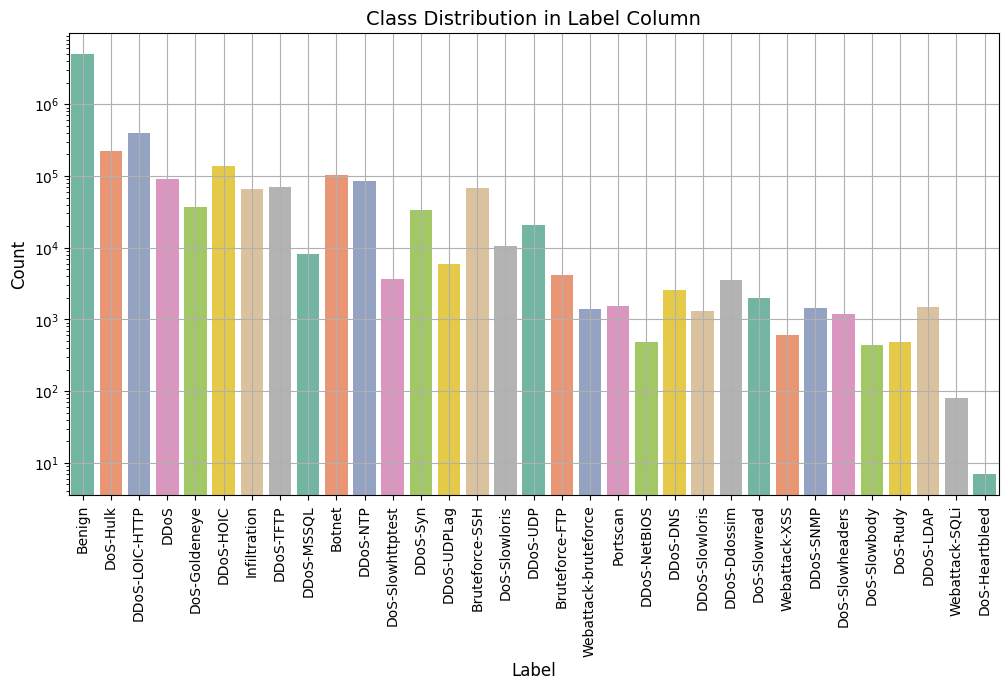

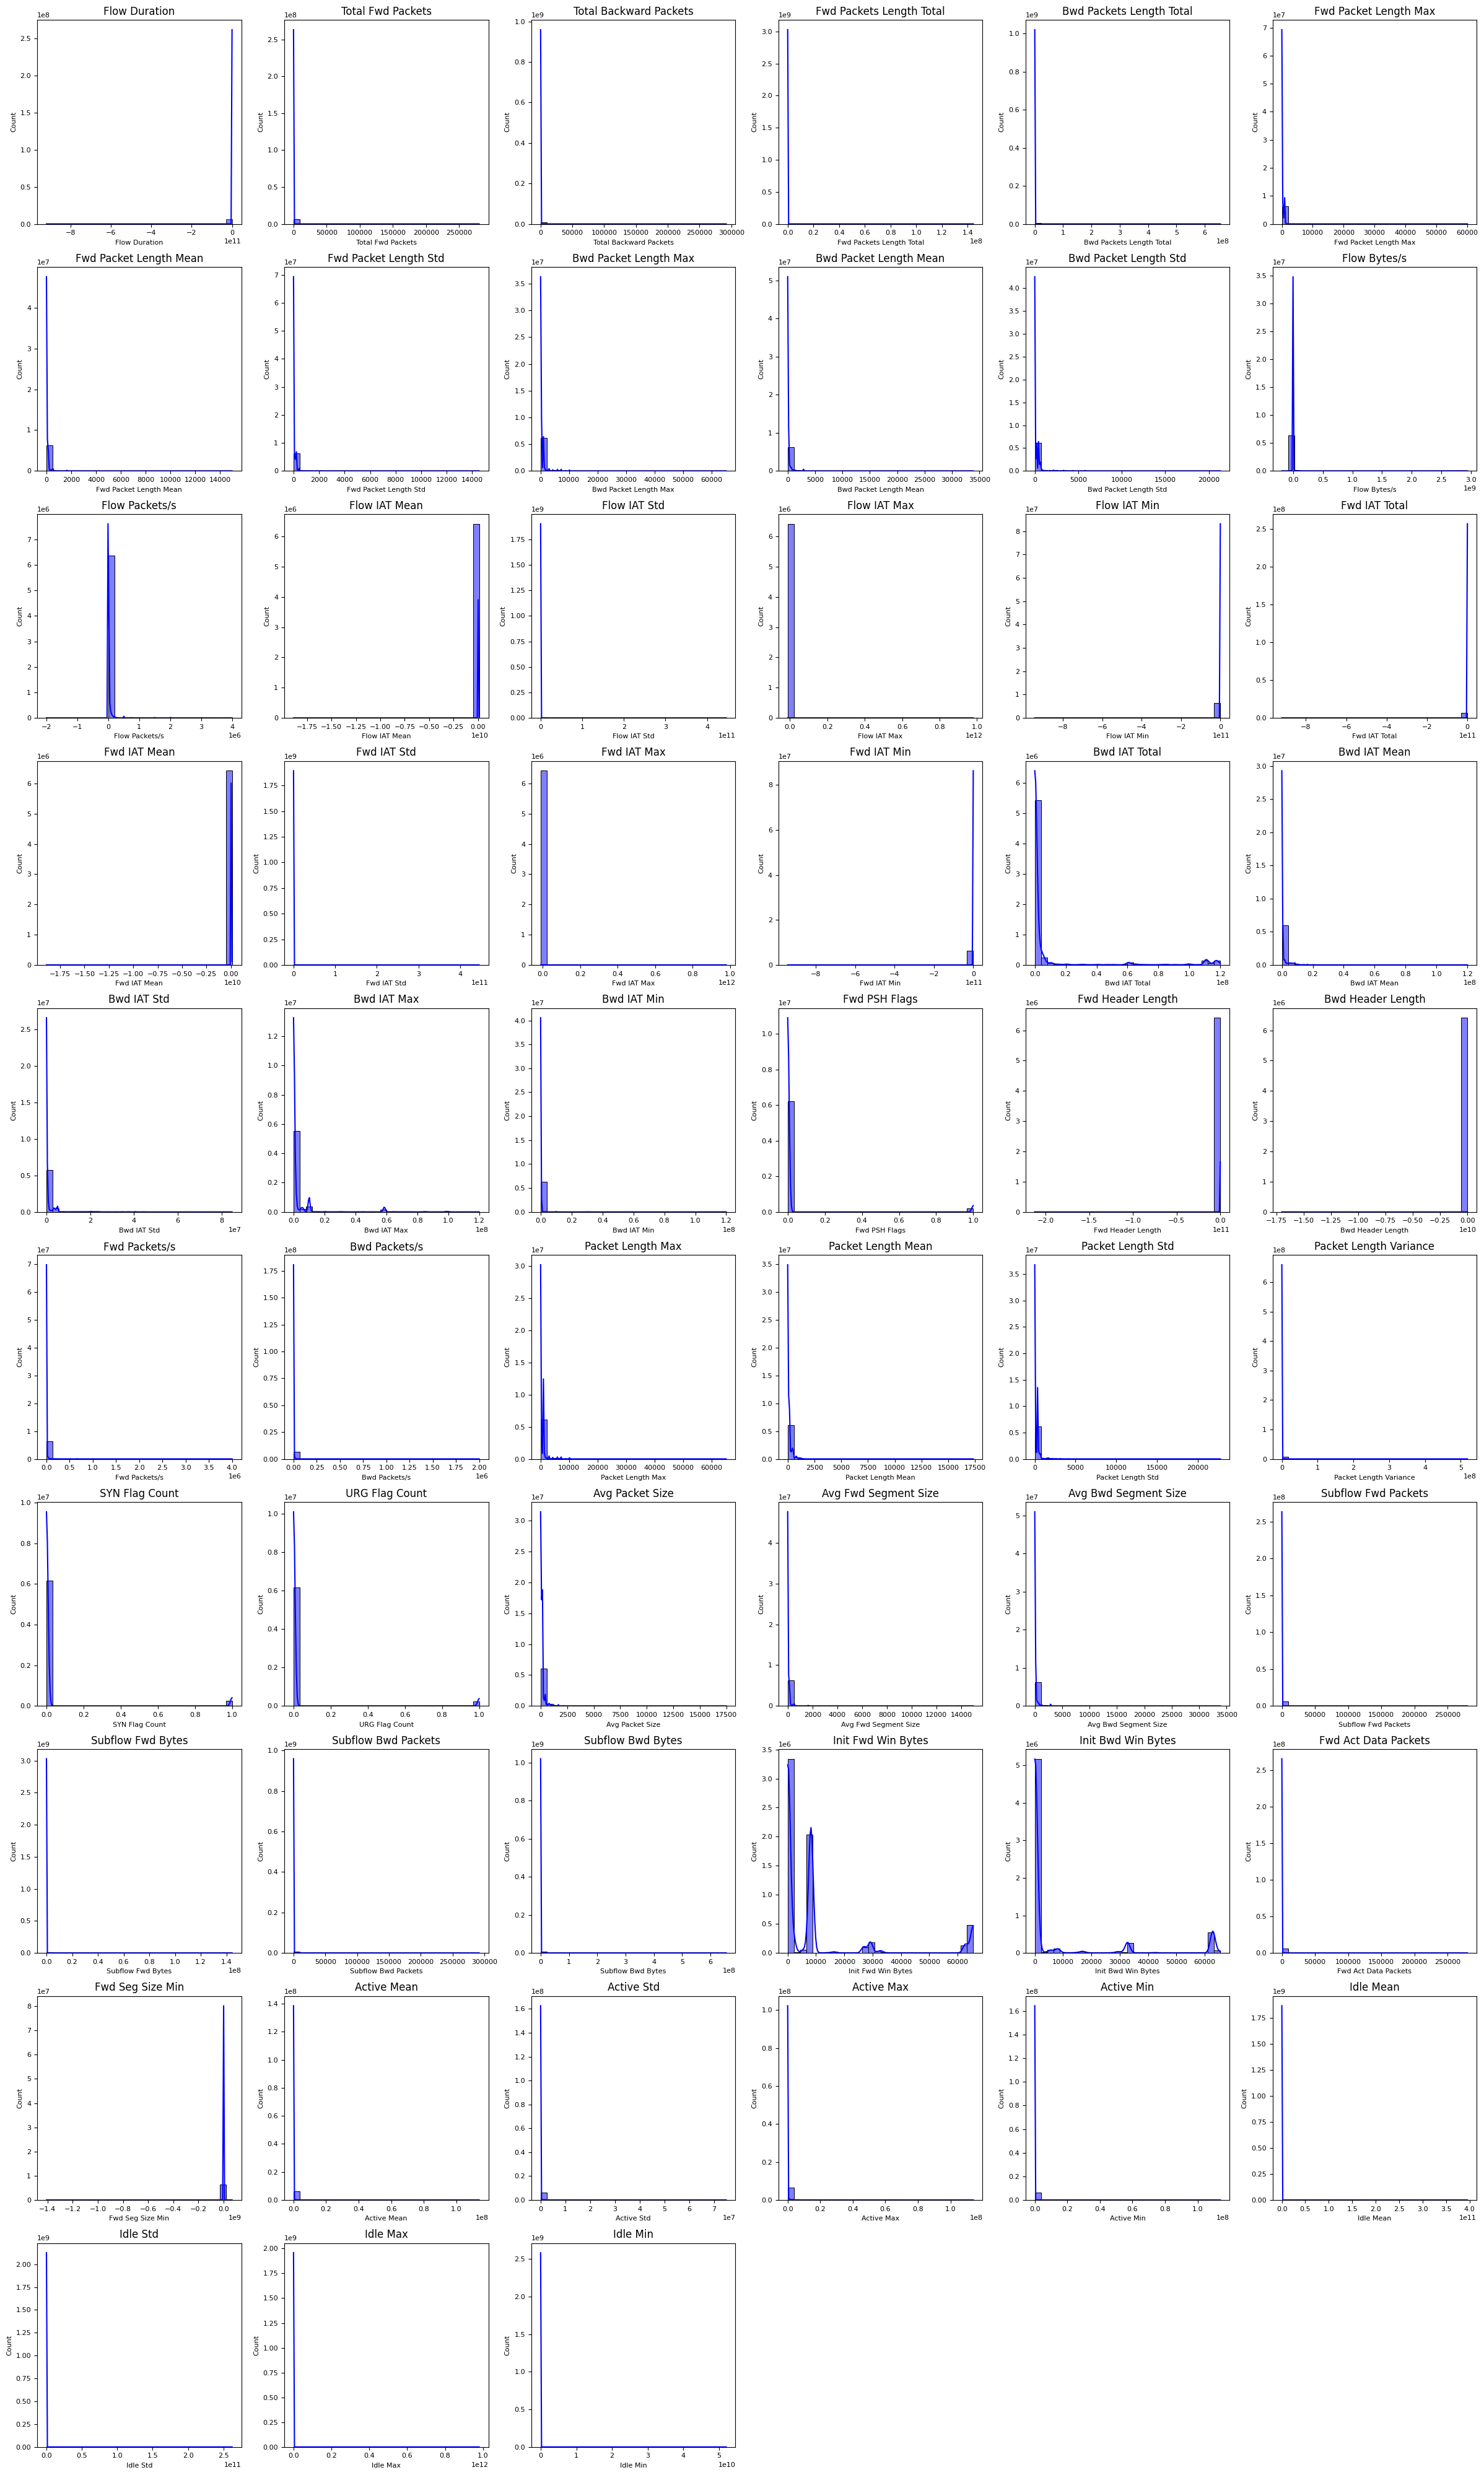

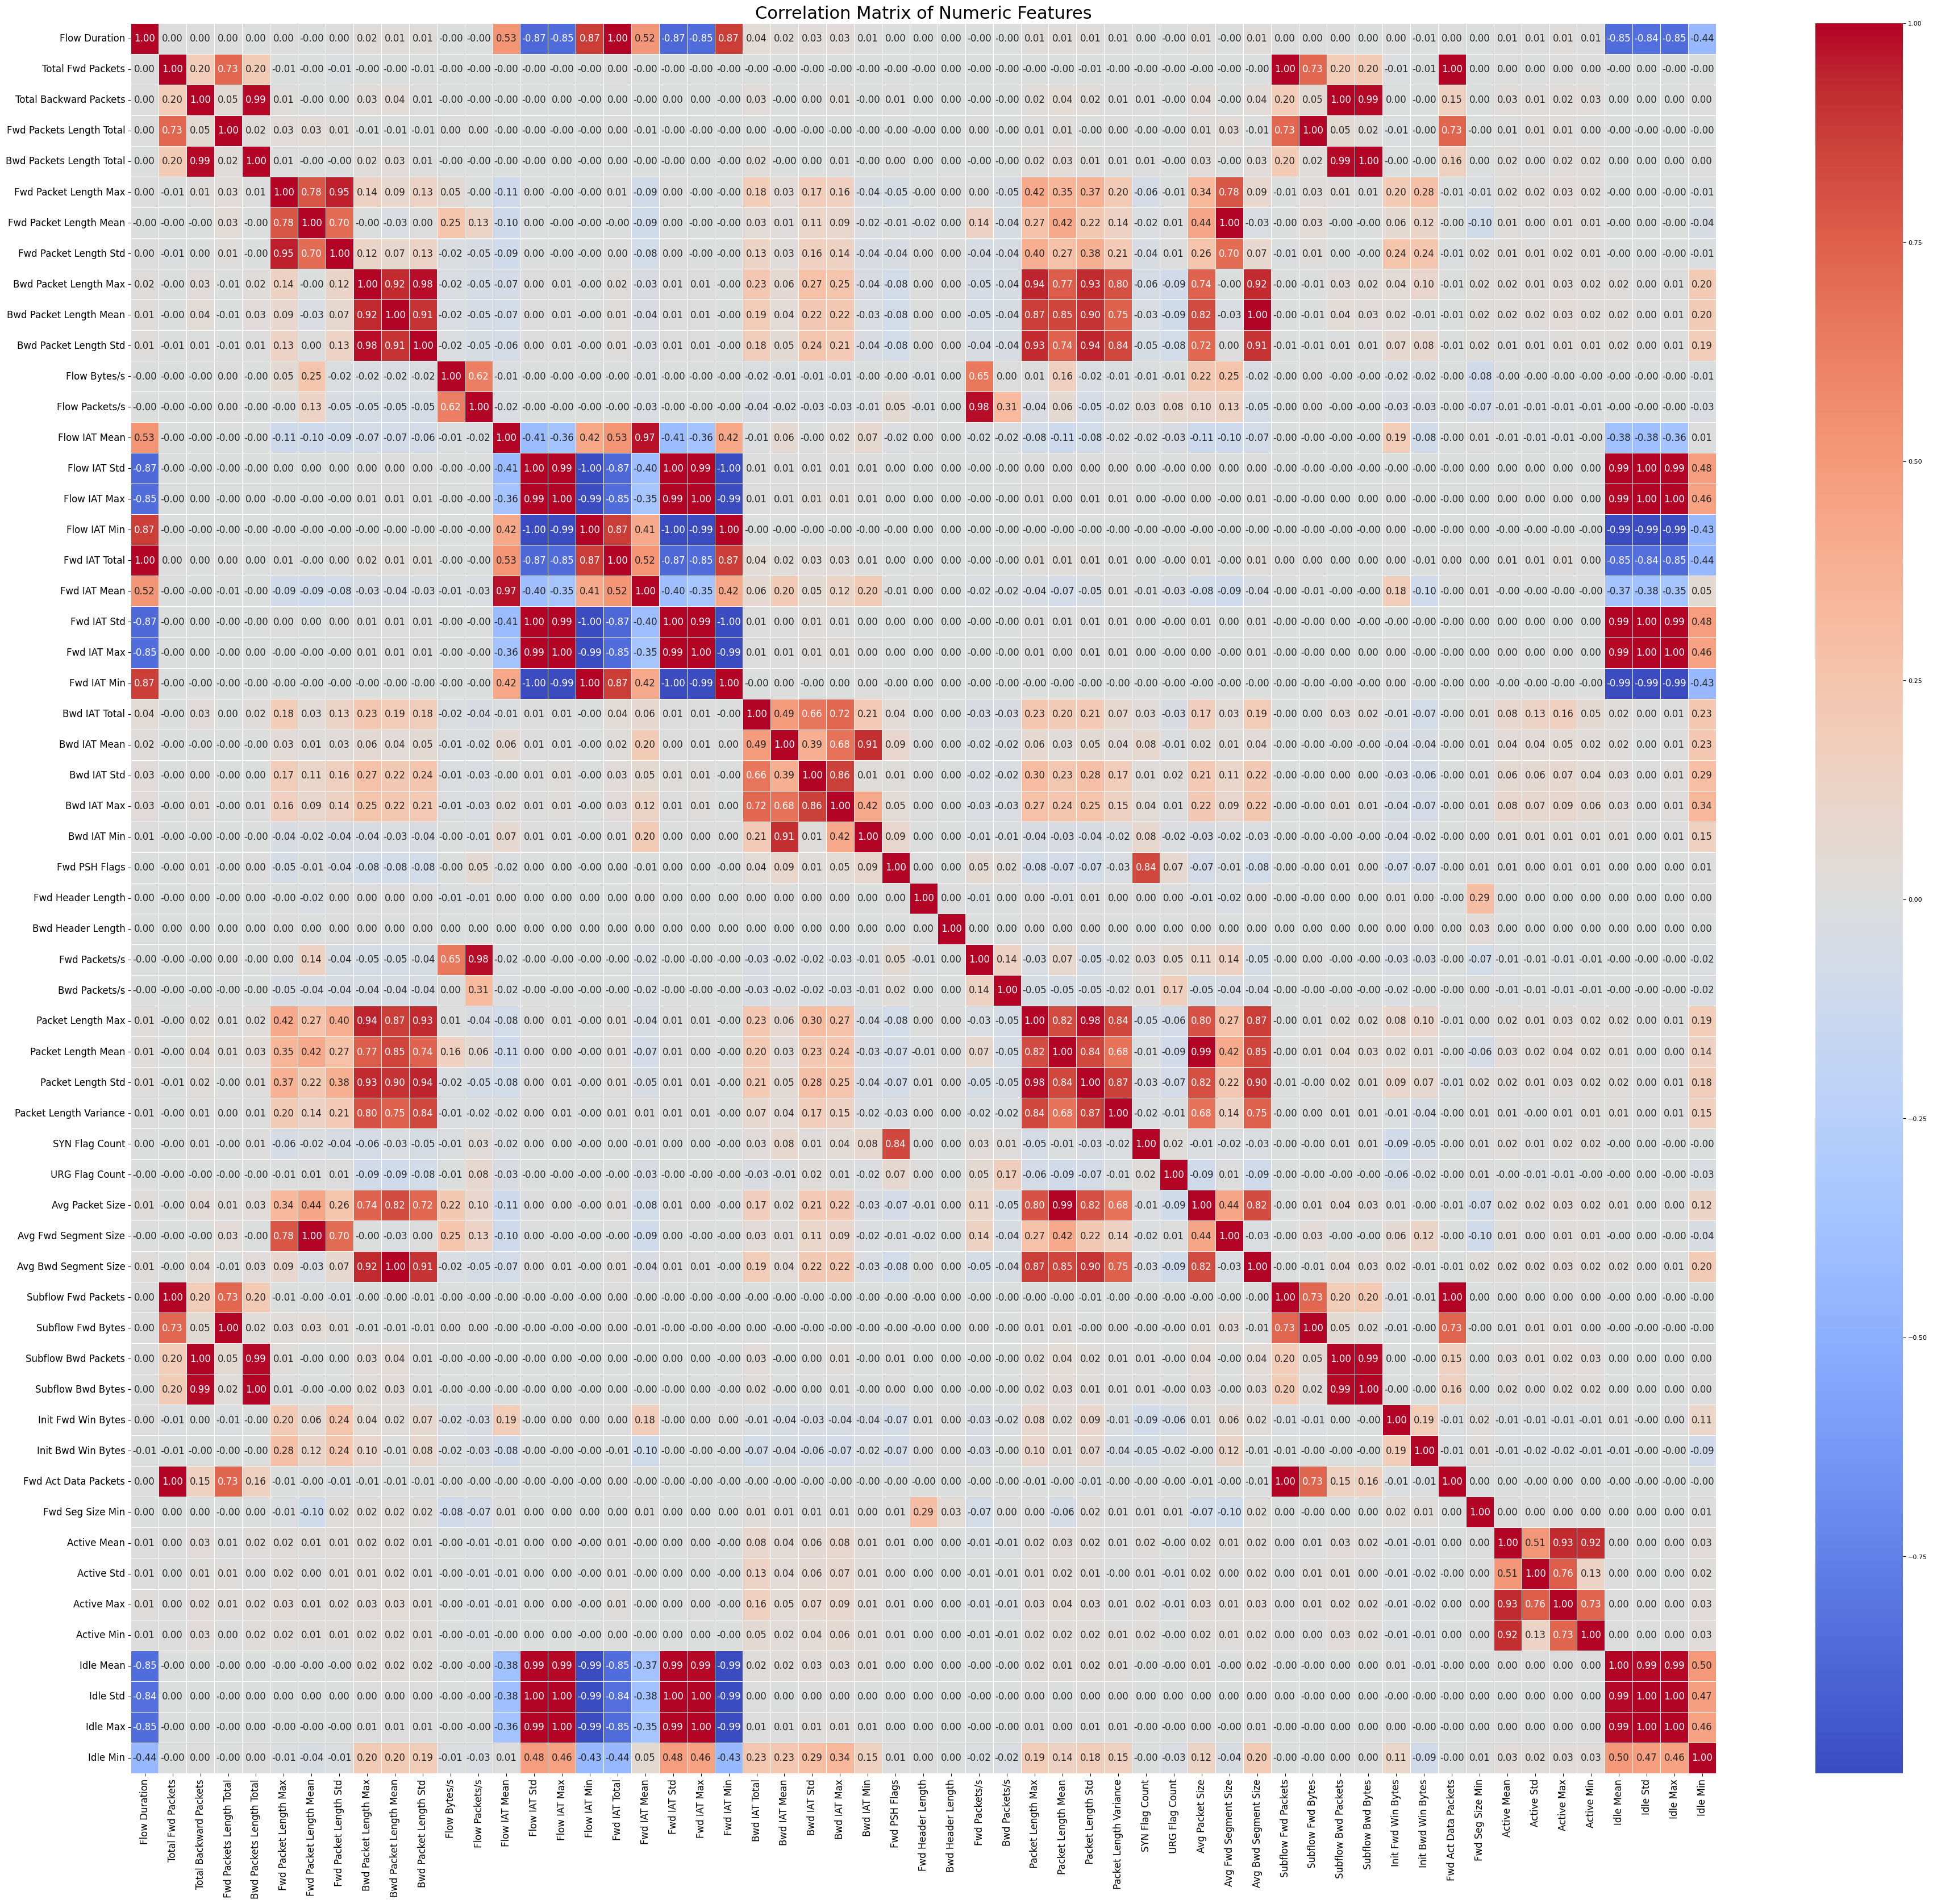

In [1]:
import import_ipynb
%run CICIDS_2019_data_preprocessing.ipynb


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class ID_CNN(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=128, kernel_size=3, num_filters=64, dropout=0.5):
        super(ID_CNN, self).__init__()

        # Step 1: Convolutional Layers for feature extraction
        # First Convolutional Layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        # Second Convolutional Layer
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters * 2, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        # Third Convolutional Layer
        self.conv3 = nn.Conv1d(in_channels=num_filters * 2, out_channels=num_filters * 4, kernel_size=kernel_size, stride=1, padding=kernel_size//2)

        # Step 2: Pooling Layers (Max pooling to reduce dimensionality)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)  # Reduce dimensionality after the first convolution
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)  # Reduce dimensionality after the second convolution
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)  # Reduce dimensionality after the third convolution

        # Step 3: Fully connected layers (for classification)
        # Flattening the features after pooling
        self.fc1 = nn.Linear(num_filters * 4 * (input_dim // 8), hidden_dim)  # Adjust input dimension after pooling
        self.fc2 = nn.Linear(hidden_dim, num_classes)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # Ensure input shape is [batch_size, channels, length]
        # Apply convolution layers for feature extraction
        x = self.conv1(x)  # [batch_size, num_filters, seq_len]
        x = torch.relu(x)
        x = self.pool1(x)  # Apply max pooling

        x = self.conv2(x)  # [batch_size, num_filters*2, reduced_seq_len]
        x = torch.relu(x)
        x = self.pool2(x)  # Apply max pooling

        x = self.conv3(x)  # [batch_size, num_filters*4, further_reduced_seq_len]
        x = torch.relu(x)
        x = self.pool3(x)  # Apply max pooling

        # Flatten the tensor for fully connected layers
        x = x.view(x.size(0), -1)  # Flatten the output

        # Apply fully connected layers
        x = torch.relu(self.fc1(x))  # [batch_size, hidden_dim]
        x = self.dropout(x)
        x = self.fc2(x)  # [batch_size, num_classes]

        return x


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Define device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(X_train, y_train, X_val, y_val, X_test, y_test, labels, patience=5):
    num_classes = len(labels)
    input_dim = X_train.shape[1]
    model = ID_CNN(input_dim=input_dim, num_classes=num_classes).to(device)  # Move model to device
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Add learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, threshold=1e-6, min_lr=1e-6)

    # Reshape the data for Conv1d (adding channel dimension)
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)  # Shape: (samples, 1, input_dim)
    X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train, torch.tensor(y_train, dtype=torch.long).to(device))
    val_dataset = TensorDataset(X_val, torch.tensor(y_val, dtype=torch.long).to(device))
    test_dataset = TensorDataset(X_test, torch.tensor(y_test, dtype=torch.long).to(device))

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Early stopping variables
    best_val_acc = 0.0
    epochs_without_improvement = 0
    best_model_weights = None

    # Training loop
    for epoch in range(100):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validate the model
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        val_accuracy = correct / total
        val_loss /= len(val_loader)

        # Step the scheduler based on validation accuracy
        scheduler.step(val_accuracy)

        print(f"Epoch {epoch + 1}, Loss: {running_loss:.6f}, Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.6f}, Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping check
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_weights = model.state_dict()  # Save the best model
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs with no improvement in validation accuracy.")
            break

    # Load the best model weights
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    # Evaluate on the test set
    model.eval()
    y_pred = []
    y_true = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(targets.tolist())
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    test_accuracy = correct / total

    # Print test set accuracy
    print(f"CICIDS_2019_ID_CNN_accuracy: {test_accuracy:.6f}")

    return model, labels, y_true, y_pred


# Call the function
model, labels, y_test_true, y_test_pred = train_model(X_train, y_train, X_val, y_val, X_test, y_test, labels)


Epoch 1, Loss: 19601.589795, Validation Loss: 0.076823, Validation Accuracy: 0.992465, Learning Rate: 0.001000
Epoch 2, Loss: 97462.134807, Validation Loss: 0.057662, Validation Accuracy: 0.992640, Learning Rate: 0.001000
Epoch 3, Loss: 182995.420840, Validation Loss: 0.035302, Validation Accuracy: 0.991891, Learning Rate: 0.001000
Epoch 4, Loss: 58030.512738, Validation Loss: 0.043213, Validation Accuracy: 0.990186, Learning Rate: 0.001000
Epoch 5, Loss: 136250.463483, Validation Loss: 0.079049, Validation Accuracy: 0.985859, Learning Rate: 0.001000
Epoch 6, Loss: 568409.366368, Validation Loss: 0.091625, Validation Accuracy: 0.983340, Learning Rate: 0.000500
Epoch 7, Loss: 218236.865170, Validation Loss: 0.064898, Validation Accuracy: 0.984922, Learning Rate: 0.000500
Early stopping triggered after 7 epochs with no improvement in validation accuracy.
CICIDS_2019_ID_CNN_accuracy: 0.985175


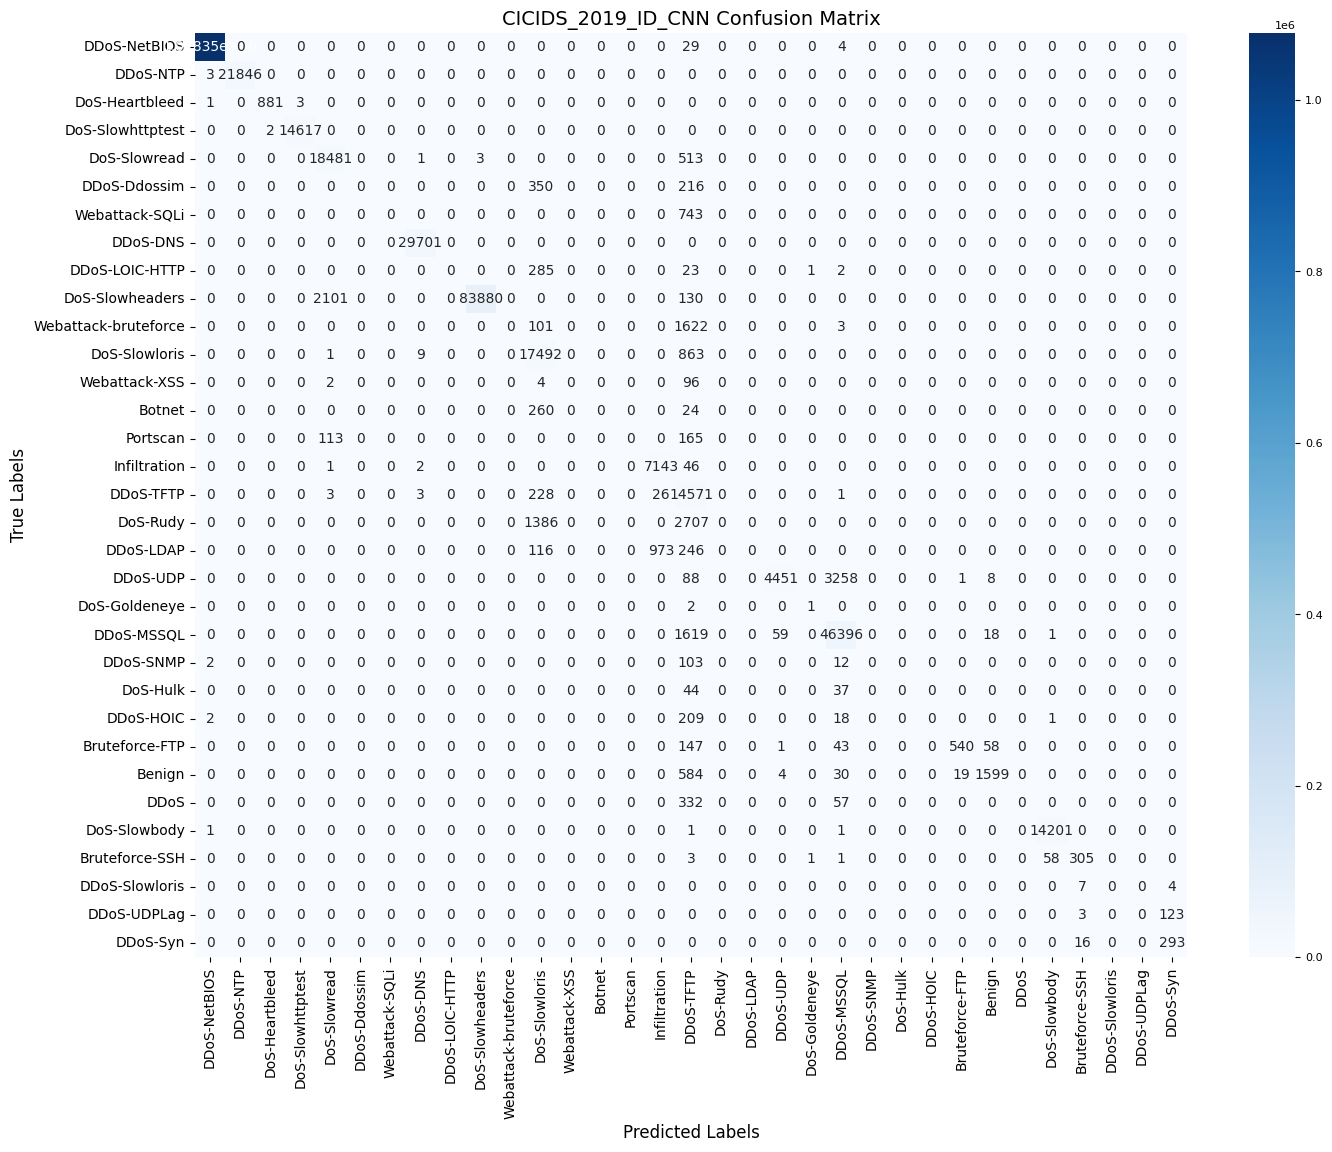

CICIDS_2019_ID_CNN Classification Report:


/home/work/soyeong/alvy/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/work/soyeong/alvy/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                      precision    recall  f1-score   support

        DDoS-NetBIOS       1.00      1.00      1.00   1078386
            DDoS-NTP       1.00      1.00      1.00     21849
      DoS-Heartbleed       1.00      1.00      1.00       885
    DoS-Slowhttptest       1.00      1.00      1.00     14619
        DoS-Slowread       0.89      0.97      0.93     18998
        DDoS-Ddossim       0.00      0.00      0.00       566
      Webattack-SQLi       0.00      0.00      0.00       743
            DDoS-DNS       1.00      1.00      1.00     29701
      DDoS-LOIC-HTTP       0.00      0.00      0.00       311
     DoS-Slowheaders       1.00      0.97      0.99     86111
Webattack-bruteforce       0.00      0.00      0.00      1726
       DoS-Slowloris       0.86      0.95      0.91     18365
       Webattack-XSS       0.00      0.00      0.00       102
              Botnet       0.00      0.00      0.00       284
            Portscan       0.00      0.00      0.00       278
       

/home/work/soyeong/alvy/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Plotting confusion matrix for Meta Model
cm_meta = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(16, 12))
sns.heatmap(cm_meta, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 10})
plt.title("CICIDS_2019_ID_CNN Confusion Matrix", fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10) 
plt.show()

print("CICIDS_2019_ID_CNN Classification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=labels))
